In [159]:
# import library
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import xlsxwriter

import pythainlp
import pythaispell
from gingerit.gingerit import GingerIt
from langdetect import detect
import nltk
from keras import *
from keras.utils import to_categorical
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
from pythainlp.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words
from stop_words import get_stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from pythainlp.corpus.common import thai_words
from pythainlp.tokenize import dict_trie
from pythainlp.tag.named_entity import ThaiNameTagger
from pythainlp.word_vector import get_model
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split



In [160]:
# Try entity extraction from hand-labeld data

# import data from Excel
df = pd.read_excel('./Data/Sheet0_token_test.xlsx',sheet_name=None)
df

OrderedDict([('Sheet1',       No  idx                word   pos tag
              0      0    0  SmartphonesSAMSUNG  NCMN   O
              1      1    0              Galaxy  NCMN   O
              2      2    0                   A  NCMN   O
              3      3    0                  20  DCNM   O
              4      4    0                   s  NCMN   O
              ..   ...  ...                 ...   ...  ..
              769  769    4             Battery  NCMN   O
              770  770    4            Capacity  NCMN   O
              771  771    4                3000  NCNM   O
              772  772    4                3999  NCNM   O
              773  773    4                 mAh  CMTR   O
              
              [774 rows x 5 columns])])

In [161]:
data = df['Sheet1']
data

,No,idx,word,pos,tag
0,0,0,SmartphonesSAMSUNG,NCMN,O
1,1,0,Galaxy,NCMN,O
2,2,0,A,NCMN,O
3,3,0,20,DCNM,O
4,4,0,s,NCMN,O
...,...,...,...,...,...
769,769,4,Battery,NCMN,O
770,770,4,Capacity,NCMN,O
771,771,4,3000,NCNM,O
772,772,4,3999,NCNM,O


In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 5 columns):
No      774 non-null int64
idx     774 non-null int64
word    774 non-null object
pos     774 non-null object
tag     774 non-null object
dtypes: int64(2), object(3)
memory usage: 30.4+ KB


In [163]:
data = data.drop('No',axis=1)

In [164]:
words = list(set(data["word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

243

In [165]:
tags = list(set(data["tag"].values))
n_tags = len(tags); n_tags

5

In [166]:
pos = list(set(data["pos"].values))
n_pos = len(pos); n_pos

15

In [167]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["word"].values.tolist(),
                                                           s["pos"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [168]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('SmartphonesSamsung', 'NCMN', 'O'), ('A', 'NCMN', 'O'), ('30', 'NCNM', 'O'), ('Ram', 'PUNC', 'B-ATTR'), ('464', 'NCNM', 'B-VAL'), ('GB', 'NCMN', 'I-VAL'), ('เครื่อง', 'CNIT', 'O'), ('ศูนย์', 'DCNM', 'O'), ('ไทย', 'NPRP', 'O'), ('ประกัน', 'VSTA', 'O'), ('ศูนย์', 'DCNM', 'O'), ('1', 'DCNM', 'O'), ('ปี', 'CMTR', 'O'), ('สมาร์ท', 'CNIT', 'O'), ('โฟน', 'NCMN', 'O'), ('โทรศัพท์มือถือ', 'NCMN', 'O'), ('ระบบปฏิบัติการ', 'NCMN', 'O'), ('จอแสดงผล', 'VACT', 'B-ATTR'), ('Super', 'NCMN', 'B-VAL'), ('AMOLED', 'NCMN', 'I-VAL'), ('24', 'NCNM', 'I-VAL'), ('bit', 'CMTR', 'I-VAL'), ('16', 'DCNM', 'O'), ('ล้าน', 'CNIT', 'O'), ('สี', 'CNIT', 'O'), ('หน้าจอ', 'NCMN', 'O'), ('หยดน้ำ', 'NCMN', 'O'), ('รูป', 'NCMN', 'O'), ('ตัว', 'CNIT', 'O'), ('U', 'NCMN', 'O'), ('Infinity', 'NCMN', 'O'), ('U', 'NCMN', 'O'), ('ระบบ', 'NCMN', 'O'), ('สัมผัส', 'VACT', 'O'), ('MultiTouch', 'NCMN', 'O'), ('6.4', 'NCNM', 'I-VAL'), ('นิ้ว', 'CMTR', 'I-VAL'), ('แนว', 'NCMN', 'O'), ('ทะแยง', 'NCMN', 'O'), ('ละเอียด', 'VATT', 'O'), 

In [169]:
sentences = getter.sentences

In [170]:
sentences

[[('SmartphonesSAMSUNG', 'NCMN', 'O'),
  ('Galaxy', 'NCMN', 'O'),
  ('A', 'NCMN', 'O'),
  ('20', 'DCNM', 'O'),
  ('s', 'NCMN', 'O'),
  ('ประกัน', 'VSTA', 'O'),
  ('ศูนย์', 'DCNM', 'O'),
  ('1', 'DCNM', 'O'),
  ('ปี', 'CMTR', 'O'),
  ('อุปกรณ์', 'NCMN', 'O'),
  ('กล่อง', 'VACT', 'O'),
  ('หัว', 'NCMN', 'O'),
  ('ชาร์จ', 'NCMN', 'O'),
  ('สาย', 'NCMN', 'O'),
  ('USB', 'NCMN', 'O'),
  ('TypeCA', 'NCMN', 'O'),
  ('20', 'DCNM', 'O'),
  ('s', 'NCMN', 'O'),
  ('แถม', 'CNIT', 'O'),
  ('หูฟัง', 'NCMN', 'O'),
  ('ฟิล์ม', 'NCMN', 'O'),
  ('เคส', 'VATT', 'O'),
  ('มาจาก', 'JSBR', 'O'),
  ('SAMSUNG', 'NCMN', 'O'),
  ('ร้าน', 'NCMN', 'O'),
  ('แกะ', 'VACT', 'O'),
  ('กล่อง', 'NCMN', 'O'),
  ('สินค้า', 'NCMN', 'O'),
  ('ใบ', 'VSTA', 'O'),
  ('ประกัน', 'ADVN', 'O'),
  ('บริษัทผู้ผลิต', 'NCMN', 'O'),
  ('แบรนด์', 'NCMN', 'B-ATTR'),
  ('ซัมซุง', 'NCMN', 'B-VAL'),
  ('ประเภท', 'CLTV', 'O'),
  ('การรับประกัน', 'ADVN', 'O'),
  ('การรับประกัน', 'ADVN', 'O'),
  ('กล้อง', 'NCMN', 'O'),
  ('หน้า', 'VATT', 'O')

In [171]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
pos2idx = {p: i for i, p in enumerate(pos)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [172]:
pos2idx

{'DCNM': 0,
 'VACT': 1,
 'XVBM': 2,
 'CMTR': 3,
 'NCMN': 4,
 'NPRP': 5,
 'CLTV': 6,
 'RPRE': 7,
 'ADVN': 8,
 'VSTA': 9,
 'CNIT': 10,
 'NCNM': 11,
 'VATT': 12,
 'PUNC': 13,
 'JSBR': 14}

In [173]:
from keras.preprocessing.sequence import pad_sequences

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

P = [[pos2idx[w[1]] for w in s] for s in sentences]
P = pad_sequences(maxlen=max_len, sequences=P, padding="post", value=n_pos)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

y = [to_categorical(i, num_classes=n_tags) for i in y]

In [174]:
X.shape

(5, 75)

In [175]:
# Split data into train and test set
#X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)


In [185]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Concatenate
from keras_contrib.layers import CRF


x = layers.Input(shape=(max_len,))

model = Embedding(input_dim=n_words+1, output_dim=20,
                  input_length=max_len)(x)    

model = Bidirectional(LSTM(units=32, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(16, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

model = Model(x,out)

In [186]:
model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

C:\Users\super\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\super\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 75)                0         
_________________________________________________________________
embedding_33 (Embedding)     (None, 75, 20)            4880      
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 75, 64)            13568     
_________________________________________________________________
time_distributed_19 (TimeDis (None, 75, 16)            1040      
_________________________________________________________________
crf_18 (CRF)                 (None, 75, 5)             120       
Total params: 19,608
Trainable params: 19,608
Non-trainable params: 0
_________________________________________________________________


In [187]:
history = model.fit(X, np.array(y), batch_size=32, epochs=10,
                    validation_split=0.1, verbose=1)

C:\Users\super\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4 samples, validate on 1 samples
Epoch 1/10
4/4 [==============================] - 2s 481ms/step - loss: 1.2882 - crf_viterbi_accuracy: 0.6833 - val_loss: 1.3785 - val_crf_viterbi_accuracy: 0.5867
Epoch 2/10
4/4 [==============================] - 0s 110ms/step - loss: 1.2805 - crf_viterbi_accuracy: 0.6833 - val_loss: 1.3725 - val_crf_viterbi_accuracy: 0.5867
Epoch 3/10
4/4 [==============================] - 0s 106ms/step - loss: 1.2728 - crf_viterbi_accuracy: 0.6833 - val_loss: 1.3659 - val_crf_viterbi_accuracy: 0.5867
Epoch 4/10
4/4 [==============================] - 0s 105ms/step - loss: 1.2653 - crf_viterbi_accuracy: 0.6833 - val_loss: 1.3588 - val_crf_viterbi_accuracy: 0.5867
Epoch 5/10
4/4 [==============================] - 0s 120ms/step - loss: 1.2562 - crf_viterbi_accuracy: 0.6833 - val_loss: 1.3513 - val_crf_viterbi_accuracy: 0.5867
Epoch 6/10
4/4 [==============================] - 0s 107ms/step - loss: 1.2467 - crf_viterbi_accuracy: 0.6833 - val_loss: 1.3431 - val_crf

In [188]:
def plot_history(history):
    
    f, ax = plt.subplots(1, 2, figsize = (16, 7))
    
    acc = history.history['crf_viterbi_accuracy']
    val_acc = history.history['val_crf_viterbi_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.sca(ax[0])
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.sca(ax[1])
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

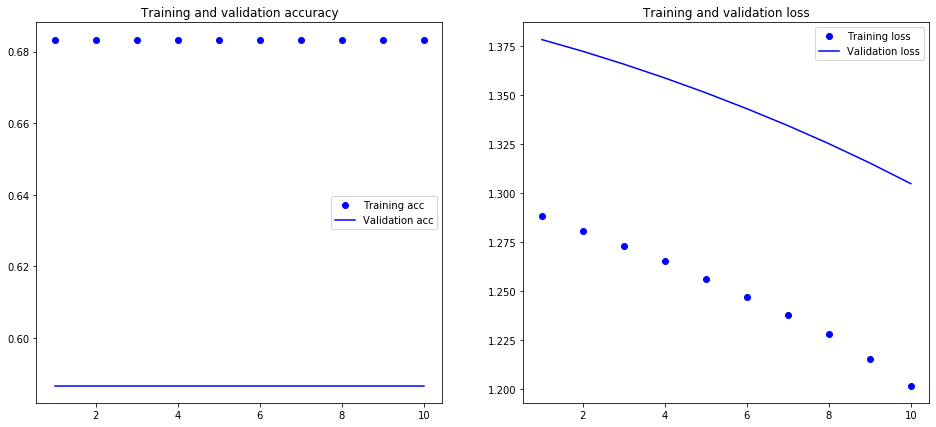

In [189]:
plot_history(history)

In [190]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

test_pred = model.predict(X, verbose=1)


5/5 [==============================] - 0s 62ms/step


In [191]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y)

In [192]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))

F1-score: 0.0%
           precision    recall  f1-score   support

      VAL       0.00      0.00      0.00        35
     ATTR       0.00      0.00      0.00        34

micro avg       0.00      0.00      0.00        69
macro avg       0.00      0.00      0.00        69



In [193]:
i = 0
p = model.predict(np.array([X[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y[i], -1)
print("{:15}||{:5}||{}".format("word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

word           ||True ||Pred
SmartphonesSAMSUNG: O     O
Galaxy         : O     O
A              : O     O
20             : O     O
s              : O     O
ประกัน         : O     O
ศูนย์          : O     O
1              : O     O
ปี             : O     O
อุปกรณ์        : O     O
กล่อง          : O     O
หัว            : O     O
ชาร์จ          : O     O
สาย            : O     O
USB            : O     O
TypeCA         : O     O
20             : O     O
s              : O     O
แถม            : O     O
หูฟัง          : O     O
ฟิล์ม          : O     O
เคส            : O     O
มาจาก          : O     O
SAMSUNG        : O     O
ร้าน           : O     O
แกะ            : O     O
กล่อง          : O     O
สินค้า         : O     O
ใบ             : O     O
ประกัน         : O     O
บริษัทผู้ผลิต  : O     O
แบรนด์         : B-ATTR O
ซัมซุง         : B-VAL O
ประเภท         : O     O
การรับประกัน   : O     O
การรับประกัน   : O     O
กล้อง          : O     O
หน้า           : O     O
เมกะ           : 